In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor)
library(data.table)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects ar

In [2]:
#First, load in the guide-level data
setwd("../data")
replicate.map = read.table("21q4_Achilles_replicate_map.csv", sep = ",", header = T)
guide.map = read.table("21q4_Achilles_guide_map.csv", sep = ",", header = T)
guide.level.data = fread("21q4_Achilles_logfold_change.csv", sep = ",", header = T, check.names = FALSE)

In [3]:
#Load in the ancestry information and create two vectors with the EAS and EUR lines
#Load in the ancestry data
setwd("../data")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [4]:
###Get a vector of all of the ancestry-associated genes

#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("../data")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene)

In [5]:
#Get a list of guides that we want to keep
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% ancestry.associated.genes) %>%
pull(sgrna)

#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = guide.level.data %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% guides.to.keep) %>%
t() %>%
data.frame() %>% 
row_to_names(1, remove_rows_above = FALSE) %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value)) %>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Warning message:
“The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Using 'mean(value)' as value column. Use 'value.var' to override



In [6]:
###Now split the dataset into EAS and EUR cell lines and perform a t-test for each sgRNA

#Split the dataset
eur.scores = guide.level.data %>%
filter(sample %in% all_of(eur.lines))

eas.scores = guide.level.data %>%
filter(sample %in% all_of(eas.lines))

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `sample %in% all_of(eur.lines)`.
Caused by warning:
! Using `all_of()` outside of a selecting function was deprecated in tidyselect
  1.2.0.
ℹ See details at
  <https://tidyselect.r-lib.org/reference/faq-selection-context.html>”


In [7]:
#First, calculate the difference in median across all of the guides
eur.median = eur.scores[2:ncol(eur.scores)] %>% apply(2, median)
eas.median = eas.scores[2:ncol(eas.scores)] %>% apply(2, median)
median.difference = eas.median - eur.median

#Now calculate a t-test between the two
t.test.vector = NULL
for(i in 2:ncol(eur.scores)){
    eas.vector = eas.scores[,i] #get a vector of sgRNA scores for the EAS lines
    eur.vector = eur.scores[,i] #get a vector of sgRNA scores for the EUR lines
    t.test.score = t.test(x = eas.vector, y = eur.vector, alternative = "two.sided")$p.value
    t.test.vector = c(t.test.vector, t.test.score)
}

In [8]:
#Load in the avana bed file
setwd("../data")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 

In [9]:
#Compile everything into a single data frame
#Also add the guide start and end position
sgrna.names = names(guide.level.data)[2:ncol(guide.level.data)]

compiled.difference.df = cbind(sgrna.names, eur.median, eas.median, t.test.vector) %>%
data.frame() %>%
mutate(eur.median = as.numeric(eur.median)) %>%
mutate(eas.median = as.numeric(eas.median)) %>%
mutate("pval" = as.numeric(t.test.vector)) %>%
rename("sgrna" = 1, "eur_median" = 2, "eas_median" = 3) %>%
mutate("differential" = eur_median - eas_median) %>%
mutate("guide_start_pos" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$start, sgrna, warn_missing = FALSE), .after = sgrna) %>%
mutate("guide_end_pos" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$end, sgrna, warn_missing = FALSE), .after = guide_start_pos) %>%
mutate("guide_chr" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$chr, sgrna, warn_missing = FALSE), .after = sgrna)
row.names(compiled.difference.df) = NULL

In [10]:
#Load in the pre-correction chronos scores
setwd("../data")
chronos.21q4 = fread("21q4_crispr_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [12]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("../data")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })



#Then fix the names on that dataset
setwd("../data")
sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(1)


final.ancestry.snp.genotyping.matrix = ccle.variant.calls
colnames(final.ancestry.snp.genotyping.matrix) = c("snp", sample.names)

In [13]:
#Filter the genotyping matrix so that it only contains the "eas" or "eur" cell lines
eas.eur.lines.to.keep = c(eas.lines, eur.lines)

genotype.matrix.eas.eur = final.ancestry.snp.genotyping.matrix %>%
select(snp, all_of(eas.eur.lines.to.keep))

In [14]:
###Next step is to figure out if any snp in genotype.matrix.eas.eur maps to a guide in compiled.difference.df
snp.in.guide.vector = NULL
for(i in 1:nrow(compiled.difference.df)){
    
    #store some useful information as variables
    guide.of.interest = compiled.difference.df[i, 1] %>% as.character()
    chr.of.interest = compiled.difference.df[i, 2] %>% as.character()
    guide.start.pos = compiled.difference.df[i, 3] %>% as.numeric()
    guide.end.pos = compiled.difference.df[i, 4] %>% as.numeric()
    
    #Filter genotype.matrix.eas.eur so that it only includes variants that fall within the guide of interest
    variants.in.guide.of.interest = genotype.matrix.eas.eur %>%
    separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt")) %>%
    filter(chr %in% all_of(chr.of.interest)) %>%
    filter(pos >= all_of(guide.start.pos)) %>%
    filter(pos <= all_of(guide.end.pos))
    
    #Calculate the number of variants that map to that guide, then save that to a vector outside of the loop
    num.variants = nrow(variants.in.guide.of.interest)
    snp.in.guide.vector[i] = num.variants
    
}

In [15]:
#create a bridging file for sgrna to gene
sgrna.gene.bridge = guide.map %>%
mutate(gene = word(gene, 1)) %>%
select(sgrna, gene)

#Add the snp information to the main data frame
compiled.difference.with.snp = compiled.difference.df %>%
mutate("snp_status" = snp.in.guide.vector) %>%
mutate("gene" = plyr::mapvalues(from = sgrna.gene.bridge$sgrna, to = sgrna.gene.bridge$gene, sgrna, warn_missing = FALSE), .after = sgrna) %>%
arrange(pval) %>%
select(-t.test.vector) %>%
mutate(snp_status = ifelse(snp_status >= 1, 1, 0)) %>%
mutate(snp_status = as.character(snp_status)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval)), .after = pval)

In [19]:
#Write the dataset used for  generating figure 3a
setwd('../output')
write.table(compiled.difference.with.snp, "figure_3a_compiled_difference.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

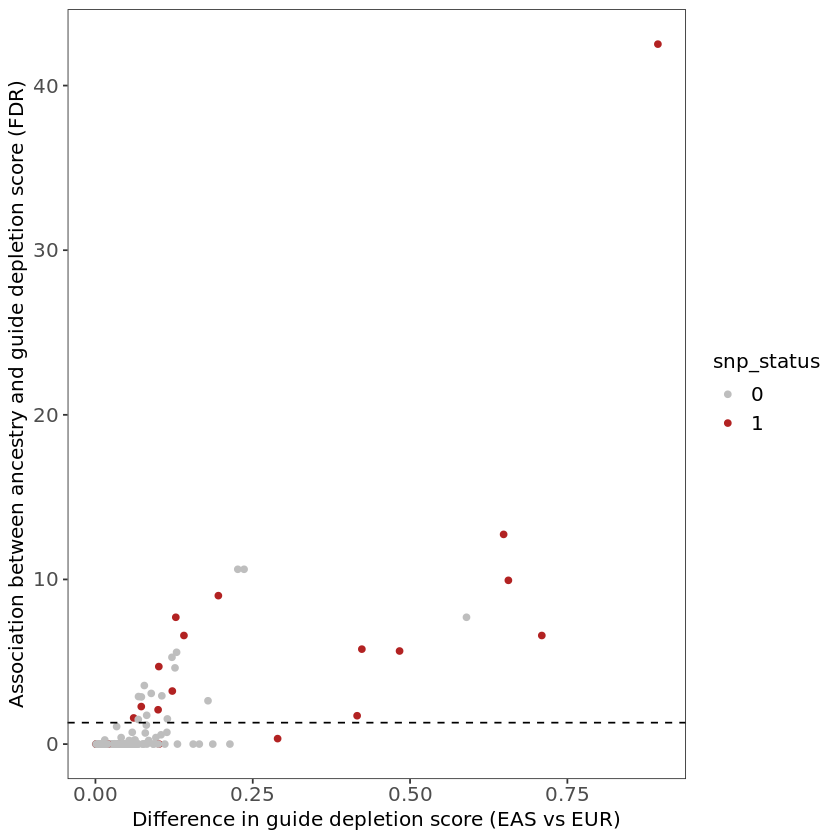

In [18]:
#Make the figure
compiled.difference.with.snp %>%
ggplot(aes(x = abs(differential), y = -log10(fdr), color = snp_status)) +
geom_point() +
geom_hline(yintercept = 1.301, linetype = 2) +
theme_bw() +

scale_color_manual(values = c("grey", "firebrick")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Association between ancestry and guide depletion score (FDR)") +
xlab("Difference in guide depletion score (EAS vs EUR)")


#Export it to the google bucket
setwd('../output')
ggsave("figure_3a.pdf", width = 4, height = 2)

In [17]:
#Compute a p-value for enrichment
with.snp.above.line = compiled.difference.with.snp %>% filter(snp_status %in% 1) %>% filter(fdr < 0.05) %>% nrow()
with.snp.below.line = compiled.difference.with.snp %>% filter(snp_status %in% 1) %>% filter(fdr > 0.05) %>% nrow()
without.snp.above.line = compiled.difference.with.snp %>% filter(snp_status %in% 0) %>% filter(fdr < 0.05) %>% nrow()
without.snp.below.line = compiled.difference.with.snp %>% filter(snp_status %in% 0) %>% filter(fdr > 0.05) %>% nrow()

fisher.matrix <- data.frame(
  "with.snp" = c(with.snp.above.line, with.snp.below.line),
  "without.snp" = c(without.snp.above.line, without.snp.below.line),
  row.names = c("above.line", "below.line"),
  stringsAsFactors = FALSE
)

fisher.matrix

fisher.test(fisher.matrix)

,with.snp,without.snp
,<int>,<int>
above.line,15,15
below.line,10,162



	Fisher's Exact Test for Count Data

data:  fisher.matrix
p-value = 1.335e-08
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  5.577822 47.257751
sample estimates:
odds ratio 
  15.78174 
